# Importing Libraries


In [5]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Dowloading dataset

In [7]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 6s 1us/step


# Plot Examples

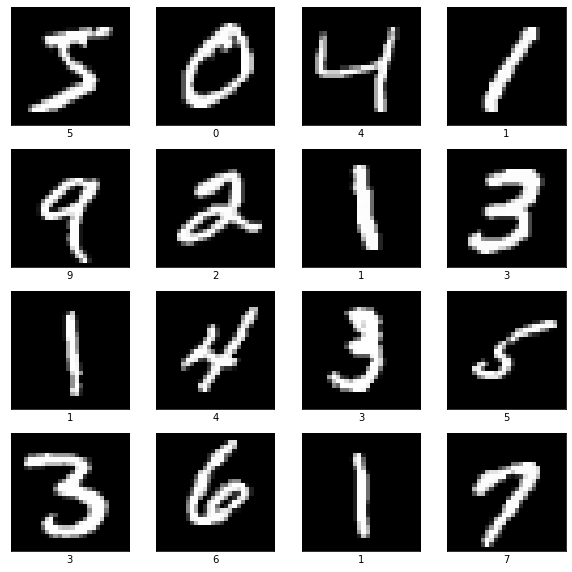

In [10]:
plt.figure(figsize=(10,10))

for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i],cmap='gray') #cmap value='binary' for white+black
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Normalize Data

In [15]:
x_train = np.reshape(x_train,(60000,28*28))
x_test = np.reshape(x_test,(10000,28*28))

x_train = x_train / 255.
x_test = x_test / 255.

# Create a Neural Network Model

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,activation='sigmoid',input_shape=(784,)),
    tf.keras.layers.Dense(32,activation='sigmoid'),
    tf.keras.layers.Dense(10,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the Model

In [20]:
_ = model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=20, batch_size=1024,
    verbose=2
)

Epoch 1/20
59/59 - 1s - loss: 0.3828 - accuracy: 0.9099 - val_loss: 0.3679 - val_accuracy: 0.9141
Epoch 2/20
59/59 - 1s - loss: 0.3538 - accuracy: 0.9141 - val_loss: 0.3419 - val_accuracy: 0.9192
Epoch 3/20
59/59 - 1s - loss: 0.3297 - accuracy: 0.9186 - val_loss: 0.3217 - val_accuracy: 0.9228
Epoch 4/20
59/59 - 1s - loss: 0.3095 - accuracy: 0.9227 - val_loss: 0.3035 - val_accuracy: 0.9257
Epoch 5/20
59/59 - 1s - loss: 0.2923 - accuracy: 0.9261 - val_loss: 0.2884 - val_accuracy: 0.9291
Epoch 6/20
59/59 - 1s - loss: 0.2773 - accuracy: 0.9297 - val_loss: 0.2759 - val_accuracy: 0.9315
Epoch 7/20
59/59 - 1s - loss: 0.2643 - accuracy: 0.9320 - val_loss: 0.2647 - val_accuracy: 0.9333
Epoch 8/20
59/59 - 1s - loss: 0.2529 - accuracy: 0.9350 - val_loss: 0.2543 - val_accuracy: 0.9366
Epoch 9/20
59/59 - 1s - loss: 0.2425 - accuracy: 0.9372 - val_loss: 0.2460 - val_accuracy: 0.9373
Epoch 10/20
59/59 - 1s - loss: 0.2331 - accuracy: 0.9393 - val_loss: 0.2378 - val_accuracy: 0.9390
Epoch 11/20
59/59 -

# Saving model

In [21]:
model.save('model.h5')

# ML Server

In [3]:
%%writefile ml_server.py
import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app=Flask(__name__)

model=tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)
_, (x_test,_) = tf.keras.datasets.mnist.load_data()
x_test = x_test/255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image=x_test[index,:,:]
    image_arr=np.reshape(image,(1,784))
    return feature_model.predict(image_arr),image

@app.route('/', methods=['GET','POST'])
def index():
    if request.method == 'POST':
        preds, image= get_prediction()
        final_preds=[p.tolist() for p in preds]
        return json.dumps({
            'prediction': final_preds,
            'image': image.tolist()
        })
    else:
        return 'LOL'
    
if __name__ == '__main__':
    app.run()

Overwriting ml_server.py


# Streamlit application

In [9]:
%%writefile app.py
import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
st.set_option('deprecation.showPyplotGlobalUse', False)
URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')

if st.button('Get random prediction'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image,(28,28))
    
    st.sidebar.image(image,width=150)
    
    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        plt.figure(figsize=(32,4))
        
        if layer==2:
            row=1
            col=10
        else:
            row=2
            col=16
            
        for i,number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer==2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05,hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()

Overwriting app.py
